<a id="0"></a> <br>
 # İçindekiler
1. [CNN --- VGGNet Modeli](#1)
1. [CNN --- EfficientNetB0 Modeli](#2)
1. [CNN --- MobileNetV2 Modeli](#3)
1. [CNN --- DenseNet121 Modeli](#4)

In [3]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
import os

from tensorflow.keras.preprocessing.image import ImageDataGenerator
from sklearn.model_selection import train_test_split
from tensorflow import keras

from tensorflow.keras.applications import VGG16
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, Dropout, BatchNormalization, GlobalAveragePooling2D


import warnings
warnings.filterwarnings("ignore")

In [4]:
directory= '/kaggle/input/a-large-scale-fish-dataset/Fish_Dataset/Fish_Dataset'
classes= [i for i in os.listdir(directory) if '.' not in i ]
classes

['Hourse Mackerel',
 'Black Sea Sprat',
 'Sea Bass',
 'Red Mullet',
 'Trout',
 'Striped Red Mullet',
 'Shrimp',
 'Gilt-Head Bream',
 'Red Sea Bream']

In [5]:
label= []
path = []

for  dir_name, _,filenames in os.walk(directory):
     for filename in filenames:
        if dir_name.split()[-1] != 'GT':
            if os.path.splitext(filename)[-1]== '.png':
                label.append(os.path.split(dir_name)[-1])
                path.append(os.path.join(dir_name, filename))

data= pd.DataFrame(columns=['path', 'label'])
data['path']= path
data['label']= label

In [6]:
data

,path,label
0,/kaggle/input/a-large-scale-fish-dataset/Fish_...,Hourse Mackerel
1,/kaggle/input/a-large-scale-fish-dataset/Fish_...,Hourse Mackerel
2,/kaggle/input/a-large-scale-fish-dataset/Fish_...,Hourse Mackerel
3,/kaggle/input/a-large-scale-fish-dataset/Fish_...,Hourse Mackerel
4,/kaggle/input/a-large-scale-fish-dataset/Fish_...,Hourse Mackerel
...,...,...
8995,/kaggle/input/a-large-scale-fish-dataset/Fish_...,Red Sea Bream
8996,/kaggle/input/a-large-scale-fish-dataset/Fish_...,Red Sea Bream
8997,/kaggle/input/a-large-scale-fish-dataset/Fish_...,Red Sea Bream
8998,/kaggle/input/a-large-scale-fish-dataset/Fish_...,Red Sea Bream


In [7]:
data.path[0]

'/kaggle/input/a-large-scale-fish-dataset/Fish_Dataset/Fish_Dataset/Hourse Mackerel/Hourse Mackerel/00929.png'

In [8]:
data.label.value_counts()

label
Hourse Mackerel       1000
Black Sea Sprat       1000
Sea Bass              1000
Red Mullet            1000
Trout                 1000
Striped Red Mullet    1000
Shrimp                1000
Gilt-Head Bream       1000
Red Sea Bream         1000
Name: count, dtype: int64

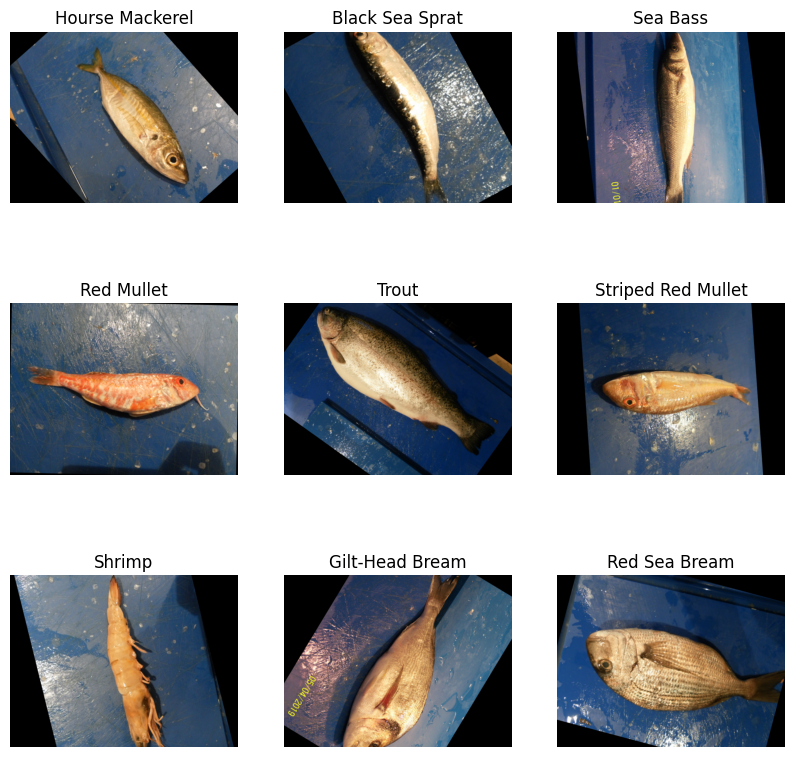

In [9]:
cn=0
plt.figure(figsize=(10,10))
for unique_label in data['label'].unique():
    plt.subplot(3,3,cn+1)
    plt.imshow(plt.imread(data[data['label']== unique_label].iloc[0,0]))
    plt.title(unique_label)
    plt.axis("off")
    cn +=1

<H2> Rescale:</H2><H3>Piksel degerini ölçeklendirmek için kullanılır.Renkli bir görüntüde bir pikselin degeri 0-225 arasında değişir.her piksel degerini 225'e bölünerek 0-1 aralıgına getirilmesi saglanır.<br><br><p>Rescale, Normalizasyon ve Daha düşük hesaplama gücü sağlar.</p> </H3>

In [10]:
# Görüntü veri artırma ve ön işleme
train_datagen= ImageDataGenerator(
    rescale= 1./255,  # 0-1 aralıgına normalleştirilir
    validation_split= 0.2 # Egitim verilerinin %20 sini dogrulama için ayırma
)

In [11]:
#Egitim verilerini yükleme ve ayrıştırma

train_genarator= train_datagen.flow_from_directory(
    directory=directory,
    target_size=(224,224),# boyutu
    batch_size= 32, # her bir adımda kullanılan görüntü sayısı
    class_mode= 'categorical',
    subset='training' 
)
#dogrulama verilerini yükleme
validation_generator= train_datagen.flow_from_directory(
        directory=directory,
        target_size=(224,224),# boyutu
        batch_size= 32, # her bir adımda kullanılan görüntü sayısı
        class_mode= 'categorical',
        subset='validation'
)

Found 14400 images belonging to 9 classes.
Found 3600 images belonging to 9 classes.


<h3> Class_indices:</h3> <h3>Veride bulunan sınıflara karşılık olarak sayısal etiketlerin  sözlük olarak saklandığı bir özelliktir.
Modelin eğitilmesi sırasında doğru sınıf etiketleriyle çalışmasını sağlar. Hangi sınıfın hangi etikete karşılık geldigini anlamak için kullanılır. </h3>

In [12]:
display(train_genarator.class_indices)

{'Black Sea Sprat': 0,
 'Gilt-Head Bream': 1,
 'Hourse Mackerel': 2,
 'Red Mullet': 3,
 'Red Sea Bream': 4,
 'Sea Bass': 5,
 'Shrimp': 6,
 'Striped Red Mullet': 7,
 'Trout': 8}

In [13]:
#kaç tane categori oldugunu göstermektedir.
num_classes= len(train_genarator.class_indices)
num_classes

9

<a id="1"></a> 
# 1. CNN --- VGGNet Modeli

In [14]:
vgg16_model= VGG16(
    include_top=False,
    weights="imagenet",
    input_shape=(224,224,3)
)

58889256/58889256 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


In [15]:
for layer in vgg16_model.layers:
    layer.trainable= False

In [16]:
inputs= vgg16_model.input

x = GlobalAveragePooling2D()(vgg16_model.output)

#Tam bağlı katmanlar ekleme
x = Dense(256, activation='relu')(x)  # Daha geniş bir katman
x = BatchNormalization()(x)            # Normalizasyon
x = Dropout(rate=0.4)(x)

x = Dense(128, activation='relu')(x)   # Ekstra katman
x = BatchNormalization()(x)
x = Dropout(rate=0.3)(x)

x = Dense(64, activation='relu')(x)

# Çıkış katmanı
outputs = Dense(9, activation='softmax')(x)

# Modelin oluşturulması
model = Model(inputs=inputs, outputs=outputs)

In [17]:
# Modelin derlenmesi
model.compile(optimizer='adam',
              loss='categorical_crossentropy',
              metrics=['accuracy'])

# Modelin yapısını görüntüleme
model.summary()

Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)        │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_conv1 (Conv2D)           │ (None, 224, 224, 64)   │         1,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_conv2 (Conv2D)           │ (None, 224, 224, 64)   │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_pool (MaxPooling2D)      │ (None, 112, 112, 64)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_conv1 (Conv2D)           │ (None, 112, 112, 128)  │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_conv2 (Conv2D)           │ (None, 112, 112, 128)  │       147,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_pool (MaxPooling2D)      │ (None, 56, 56, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv1 (Conv2D)           │ (None, 56, 56, 256)    │       295,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv2 (Conv2D)           │ (None, 56, 56, 256)    │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv3 (Conv2D)           │ (None, 56, 56, 256)    │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_pool (MaxPooling2D)      │ (None, 28, 28, 256)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv1 (Conv2D)           │ (None, 28, 28, 512)    │     1,180,160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv2 (Conv2D)           │ (None, 28, 28, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv3 (Conv2D)           │ (None, 28, 28, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_pool (MaxPooling2D)      │ (None, 14, 14, 512)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv1 (Conv2D)           │ (None, 14, 14, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv2 (Conv2D)           │ (None, 14, 14, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv3 (Conv2D)           │ (None, 14, 14, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_pool (MaxPooling2D)      │ (None, 7, 7, 512)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d        │ (None, 512)            │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 256)            │       131,328 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 256)            │         1,024 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 128)            │        32,89

 Total params: 14,889,289 (56.80 MB)

 Trainable params: 173,833 (679.04 KB)

 Non-trainable params: 14,715,456 (56.14 MB)

In [ ]:
 history = model.fit(
        train_genarator,
        epochs=5,
        validation_data= validation_generator)

Epoch 1/5
239/450 ━━━━━━━━━━━━━━━━━━━━ 31:43 9s/step - accuracy: 0.4313 - loss: 1.6302

In [ ]:
loss, accuracy = model.evaluate(validation_generator)
print(f'loss: {loss}')
print(f'accuracy: {accuracy}')

In [ ]:
import sklearn.metrics as metrics
Evaluation = pd.DataFrame(['VGGNet'],columns=['Algorithm'])
Evaluation.loc[0,'Accuracy']= accuracy

In [ ]:
#egitim sonuçlarını görselleştirme
plt.figure(figsize=(12,5))

#loss grafigi
plt.subplot(1,2,1)
plt.plot(history.history['loss'],label='Train Loss')
plt.plot(history.history['val_loss'],label= 'Validation loss')
plt.title('Loss Grafigi')
plt.xlabel('Epochs')
plt.ylabel('loss')
plt.legend()


#Accuracy grafigi
plt.subplot(1,2,2)
plt.plot(history.history['accuracy'],label='Train Accuracy')
plt.plot(history.history['val_accuracy'],label= 'Validation Accuracy')
plt.title('Accuracy Grafigi')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.tight_layout()
plt.show()

<p style="font-size: 20px;">Loss grafiginde,epoch degeri arttikça  loss degeri düşmektedir.hata degeri azalmaktadir.
       
    accuracy grafiginde,epoch degeri veriyi egittikçe arccuracy degeri dogruluk değeri artmaktadir.
</p>

<p> <h3>
Aşırı Öğrenme (Overfitting):

Eğitim kaybı sürekli azalırken doğrulama kaybı artmaya başlıyorsa.
Eğitim doğruluğu yüksek ve doğrulama doğruluğu düşük kalıyorsa.
Genellikle daha fazla epoch eğitim yapıldıkça ortaya çıkar.

Eksik Öğrenme (Underfitting):

Eğitim ve doğrulama kaybı yüksek kalıyorsa ve düşmüyorsa.
Eğitim ve doğrulama doğrulukları düşük kalıyorsa.
Genellikle model yeterince karmaşık olmadığında veya eğitim süresi kısa olduğunda görülür.

</h3></p>

In [ ]:
prediction= model.predict(validation_generator)
predictions= np.argmax(prediction,axis=1)

In [ ]:
from sklearn.metrics import confusion_matrix, classification_report
y_true= validation_generator.classes
confusionMatris= confusion_matrix(y_true,predictions)
plt.figure(figsize=(6,4))
sns.heatmap(confusionMatris,annot=True,fmt='d',cmap='Blues', xticklabels= validation_generator.class_indices,yticklabels= validation_generator.class_indices)
plt.xlabel('predicted label')
plt.ylabel('True Label')
plt.title('Confusion Matrix')
plt.show()

In [ ]:
report= classification_report(y_true,predictions, target_names=list(validation_generator.class_indices.keys()))
print(report)

<a id="2"></a>
# 2. CNN--------EfficientNetB0

In [ ]:
from tensorflow.keras.applications import EfficientNetB0

model_EfficientNetB0= EfficientNetB0(
    include_top=False,
    weights="imagenet",
    input_shape=(224,224,3)
)
 
model_EfficientNetB0.trainable= False

In [ ]:
inputs= model_EfficientNetB0.input

x = GlobalAveragePooling2D()(model_EfficientNetB0.output)

#Tam bağlı katmanlar ekleme
x = Dense(256, activation='relu')(x)  # Daha geniş bir katman
x = BatchNormalization()(x)            # Normalizasyon
x = Dropout(rate=0.5)(x)
# Çıkış katmanı
outputs = Dense(9, activation='softmax')(x)

# Modelin oluşturulması
model = Model(inputs=inputs, outputs=outputs)


In [ ]:
# Modelin derlenmesi
model.compile(optimizer='adam',
              loss='categorical_crossentropy',
              metrics=['accuracy'])

# Modelin yapısını görüntüleme
model.summary()

In [ ]:
 history1 = model.fit(
        train_genarator,
        epochs=5,
        validation_data= validation_generator)

In [ ]:
loss1, accuracy1 = model.evaluate(validation_generator)
print(f'loss: {loss1}')
print(f'accuracy: {accuracy1}')

In [ ]:
Evaluation = pd.DataFrame(['EfficientNetB0'],columns=['Algorithm'])
Evaluation.loc[1,'Accuracy']= accuracy1

In [ ]:
#egitim sonuçlarını görselleştirme
plt.figure(figsize=(12,5))

#loss grafigi
plt.subplot(1,2,1)
plt.plot(history1.history['loss'],label='Train Loss')
plt.plot(history1.history['val_loss'],label= 'Validation loss')
plt.title('Loss Grafigi')
plt.xlabel('Epochs')
plt.ylabel('loss')
plt.legend()


#Accuracy grafigi
plt.subplot(1,2,2)
plt.plot(history1.history['accuracy'],label='Train Accuracy')
plt.plot(history1.history['val_accuracy'],label= 'Validation Accuracy')
plt.title('Accuracy Grafigi')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.tight_layout()
plt.show()

In [ ]:
from sklearn.metrics import confusion_matrix, classification_report

prediction= model.predict(validation_generator)
predictions= np.argmax(prediction,axis=1)


y_true= validation_generator.classes
confusionMatris= confusion_matrix(y_true,predictions)
plt.figure(figsize=(6,4))
sns.heatmap(confusionMatris,annot=True,fmt='d',cmap='Blues', xticklabels= validation_generator.class_indices,yticklabels= validation_generator.class_indices)
plt.xlabel('predicted label')
plt.ylabel('True Label')
plt.title('Confusion Matrix')
plt.show()

In [ ]:
report= classification_report(y_true,predictions, target_names=list(validation_generator.class_indices.keys()))
print(report)

<a id="3"></a>
# 3. CNN-----------MobileNetV2

In [ ]:
from tensorflow.keras.applications import MobileNetV2

model_MobileNetV2= MobileNetV2(
    include_top=False,
    weights="imagenet",
    input_shape=(224,224,3)
)
model_MobileNetV2.trainable= False


In [ ]:
inputs= model_MobileNetV2.input

x = GlobalAveragePooling2D()(model_MobileNetV2.output)

#Tam bağlı katmanlar ekleme
x = Dense(256, activation='relu')(x)  # Daha geniş bir katman
x = BatchNormalization()(x)            # Normalizasyon
x = Dropout(rate=0.5)(x)
# Çıkış katmanı
outputs = Dense(9, activation='softmax')(x)

# Modelin oluşturulması
model = Model(inputs=inputs, outputs=outputs)

In [ ]:
# Modelin derlenmesi
model.compile(optimizer='adam',
              loss='categorical_crossentropy',
              metrics=['accuracy'])

# Modelin yapısını görüntüleme
model.summary()

In [ ]:
 history3 = model.fit(
        train_genarator,
        epochs=5,
        validation_data= validation_generator)

In [ ]:
loss3, accuracy3 = model.evaluate(validation_generator)
print(f'loss: {loss3}')
print(f'accuracy: {accuracy3}')

In [ ]:
Evaluation = pd.DataFrame(['MobileNetV2'],columns=['Algorithm'])
Evaluation.loc[2,'Accuracy']= accuracy3

In [ ]:
#egitim sonuçlarını görselleştirme
plt.figure(figsize=(12,5))

#loss grafigi
plt.subplot(1,2,1)
plt.plot(history3.history['loss'],label='Train Loss')
plt.plot(history3.history['val_loss'],label= 'Validation loss')
plt.title('Loss Grafigi')
plt.xlabel('Epochs')
plt.ylabel('loss')
plt.legend()


#Accuracy grafigi
plt.subplot(1,2,2)
plt.plot(history3.history['accuracy'],label='Train Accuracy')
plt.plot(history3.history['val_accuracy'],label= 'Validation Accuracy')
plt.title('Accuracy Grafigi')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.tight_layout()
plt.show()

In [ ]:
from sklearn.metrics import confusion_matrix, classification_report

prediction= model.predict(validation_generator)
predictions= np.argmax(prediction,axis=1)


y_true= validation_generator.classes
confusionMatris= confusion_matrix(y_true,predictions)
plt.figure(figsize=(6,4))
sns.heatmap(confusionMatris,annot=True,fmt='d',cmap='Blues', xticklabels= validation_generator.class_indices,yticklabels= validation_generator.class_indices)
plt.xlabel('predicted label')
plt.ylabel('True Label')
plt.title('Confusion Matrix')
plt.show()

In [ ]:
report= classification_report(y_true,predictions, target_names=list(validation_generator.class_indices.keys()))
print(report)

<a id="4"></a>
# 4. CNN ------DenseNet121

In [ ]:
from tensorflow.keras.applications import DenseNet121

model_DenseNet121= DenseNet121(
    include_top=False,
    weights="imagenet",
    input_shape=(224,224,3)
)
model_DenseNet121.trainable= False

In [ ]:
inputs= model_DenseNet121.input

x = GlobalAveragePooling2D()(model_DenseNet121.output)

#Tam bağlı katmanlar ekleme
x = Dense(256, activation='relu')(x)  # Daha geniş bir katman
x = BatchNormalization()(x)            # Normalizasyon
x = Dropout(rate=0.5)(x)
# Çıkış katmanı
outputs = Dense(9, activation='softmax')(x)

# Modelin oluşturulması
model = Model(inputs=inputs, outputs=outputs)

In [ ]:
# Modelin derlenmesi
model.compile(optimizer='adam',
              loss='categorical_crossentropy',
              metrics=['accuracy'])

# Modelin yapısını görüntüleme
model.summary()

In [ ]:
 history4 = model.fit(
        train_genarator,
        epochs=5,
        validation_data= validation_generator)

In [ ]:
loss4, accuracy4 = model.evaluate(validation_generator)
print(f'loss: {loss4}')
print(f'accuracy: {accuracy4}')

In [ ]:
Evaluation = pd.DataFrame(['DenseNet121'],columns=['Algorithm'])
Evaluation.loc[3,'Accuracy']= accuracy4

In [ ]:
#egitim sonuçlarını görselleştirme
plt.figure(figsize=(12,5))

#loss grafigi
plt.subplot(1,2,1)
plt.plot(history4.history['loss'],label='Train Loss')
plt.plot(history4.history['val_loss'],label= 'Validation loss')
plt.title('Loss Grafigi')
plt.xlabel('Epochs')
plt.ylabel('loss')
plt.legend()


#Accuracy grafigi
plt.subplot(1,2,2)
plt.plot(history4.history['accuracy'],label='Train Accuracy')
plt.plot(history4.history['val_accuracy'],label= 'Validation Accuracy')
plt.title('Accuracy Grafigi')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.tight_layout()
plt.show()

In [ ]:
from sklearn.metrics import confusion_matrix, classification_report

prediction= model.predict(validation_generator)
predictions= np.argmax(prediction,axis=1)


y_true= validation_generator.classes
confusionMatris= confusion_matrix(y_true,predictions)
plt.figure(figsize=(6,4))
sns.heatmap(confusionMatris,annot=True,fmt='d',cmap='Blues', xticklabels= validation_generator.class_indices,yticklabels= validation_generator.class_indices)
plt.xlabel('predicted label')
plt.ylabel('True Label')
plt.title('Confusion Matrix')
plt.show()

In [ ]:
report= classification_report(y_true,predictions, target_names=list(validation_generator.class_indices.keys()))
print(report)

In [ ]:
print(Evaluation)